In [1]:
"""

Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20

--- Following Josh's placeholders_experiments.ipynb to create a version that works with text data

"""

'\n\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n\n--- Following Josh\'s placeholders_experiments.ipynb to create a version that works with text data\n\n'

In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
NUM_CLASSES = 100

def load_dataset():
    df = pd.read_excel(r'/content/drive/MyDrive/NLP_Fall2022/Group Project/DatasetSplit/train_split.xlsx', usecols=['label','review'])
    df_test = pd.read_excel(r'/content/drive/MyDrive/NLP_Fall2022/Group Project/DatasetSplit/test_split.xlsx', usecols=['label','review'])
    # tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.object)
    # X_train = tf.convert_to_tensor(df['review'])
    # y_train = tf.convert_to_tensor(df['label'])
    # X_test = tf.convert_to_tensor(df_test['review'])
    # y_test = tf.convert_to_tensor(df_test['label'])

    X_train = df['review']
    y_train = df['label']
    X_test = df_test['review']
    y_test = df_test['label']
    return X_train, y_train, X_test, y_test

def validation_split(X, y, val_size=.2):
    """Input are expected to be tensors.
    """
    # tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y)
    return X_train, X_val, y_train, y_val

In [4]:
X, y, X_test, y_test = load_dataset()

In [5]:
def plot_loss(train_losses, val_losses):
    iterations = list(range(len(train_losses)))
    plt.plot(iterations, train_losses, label='Train')
    plt.plot(iterations, val_losses, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.title('Loss While Training')
    plt.show()
    
def plot_acc(train_accs, val_accs):
    iterations = list(range(len(train_accs)))
    plt.plot(iterations, train_accs, label='Train')
    plt.plot(iterations, val_accs, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Accuracy While Training')
    plt.show()

In [6]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, pre_dim, post_dim, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim,  activation='relu', name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation='relu', name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        # print("2nd layer\n\n")
        # print(inputs)
        x_pre = self.embed_pre(inputs)
        # print(x_pre)
        x_post = self.embed_post(x_pre)
        # print(x_post)
        logits = self.logits_layer(x_post)
        # print(logits)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [7]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.2)

In [9]:

epochs = 500
batch_size = 64

vectorizer = TfidfVectorizer(max_features=250, sublinear_tf=True, ngram_range=(1,2))
train_features = vectorizer.fit_transform(X_train).toarray()
dev_features = vectorizer.transform(X_val).toarray()
# y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=100)
lb = LabelEncoder()
ytrain = lb.fit_transform(y_train)
dummy_y_train = np_utils.to_categorical(ytrain)

yval = lb.fit_transform(y_val)
dummy_y_dev = np_utils.to_categorical(yval)

In [10]:
pre_dim = post_dim = 200
model = StandardLogisticRegressionModel(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES
)
model.compile(
    optimizer='adam', 
    loss=ce_loss, 
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)
# y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)

# history = model.fit(X, y_train_one_hot, epochs=10, validation_split=.2)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, dummy_y_train, batch_size=batch_size,
                  callbacks=[es_callback],
          epochs=epochs, validation_data=(dev_features, dummy_y_dev))
# history = model.fit(X, y_train_one_hot, epochs=10, validation_split=.2)

Epoch 1/500
557/557 [==============================] - 5s 6ms/step - loss: 3.4419 - acc: 0.2200 - val_loss: 2.5906 - val_acc: 0.3711
Epoch 2/500
557/557 [==============================] - 3s 6ms/step - loss: 2.2765 - acc: 0.4418 - val_loss: 2.1200 - val_acc: 0.4792
Epoch 3/500
557/557 [==============================] - 4s 6ms/step - loss: 1.9325 - acc: 0.5206 - val_loss: 1.9361 - val_acc: 0.5139
Epoch 4/500
557/557 [==============================] - 4s 7ms/step - loss: 1.7376 - acc: 0.5616 - val_loss: 1.8038 - val_acc: 0.5479
Epoch 5/500
557/557 [==============================] - 4s 6ms/step - loss: 1.6091 - acc: 0.5908 - val_loss: 1.7272 - val_acc: 0.5643
Epoch 6/500
557/557 [==============================] - 3s 6ms/step - loss: 1.5057 - acc: 0.6165 - val_loss: 1.6831 - val_acc: 0.5752
Epoch 7/500
557/557 [==============================] - 4s 6ms/step - loss: 1.4255 - acc: 0.6317 - val_loss: 1.6445 - val_acc: 0.5824
Epoch 8/500
557/557 [==============================] - 3s 6ms/step - 

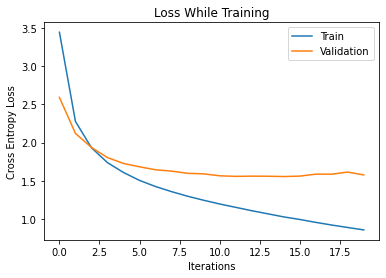

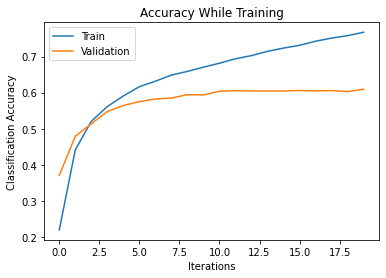

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

In [12]:

# from matplotlib import pyplot
# pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('model train vs validation loss')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper left')
# pyplot.show()
# pyplot.plot(history.history['accuracy'])
# pyplot.plot(history.history['val_accuracy'])
# pyplot.title('model train vs validation acc')
# pyplot.ylabel('acc')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper left')
# pyplot.show()
# score = model.evaluate(dev_features, dummy_y_dev, batch_size=batch_size, verbose=1)





# test_features = vectorizer.fit_transform(X_test).toarray()

# y_testval = lb.fit_transform(y_test)
# dummy_y_test = np_utils.to_categorical(y_testval)
# #Predictions 
# print ("Predict")
# y_test1 = model.predict(test_features)

# y_pred = lb.inverse_transform(np.argmax(y_test1, axis=1))


# score = model.evaluate(test_features, dummy_y_test, batch_size=batch_size, verbose=1)

# print('Test accuracy:', score[1])

In [13]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
from itertools import compress
    
def threshold_predict(X, model, threshold):
    # print(X)
    # y_pred = model.call(X)
    y_pred = model.predict(X)
    # print(y_pred)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = [y != label for label in class_labels]
    X = np.array(X) 
    result = X[to_remove_mask] 
    X=result.tolist()
    y = np.array(y) 
    result = y[to_remove_mask] 
    y=result.tolist()
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def closed_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    closed_set_idx = y_true != -1
    return accuracy(y_true[closed_set_idx], y_pred[closed_set_idx])
    #return tf.reduce_sum(tf.equal(y_true[closed_set_idx], y_pred[closed_set_idx]))

def plot_open_closed_accuracy(all_acc, open_acc, closed_acc):
    plt.plot(threshold_value, all_acc, label='All class accuracy')
    plt.plot(threshold_value, open_acc, label='Open set accuracy')
    plt.plot(threshold_value, closed_acc, label='Closed set accuracy')
    plt.xlabel('Classification Probability Threshold')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Effect of Threshold on Accuracy')
    plt.show()

In [14]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [99] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)


pre_dim = post_dim = 200
model = StandardLogisticRegressionModel(pre_dim, post_dim, NUM_CLASSES - 1)
model.compile(optimizer='adam', loss=ce_loss, metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')])





train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()

lb = LabelEncoder()
ytrain = lb.fit_transform(y_train_closed)
dummy_y_train = np_utils.to_categorical(ytrain)

yval = lb.fit_transform(y_val_closed)
dummy_y_dev = np_utils.to_categorical(yval)


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, dummy_y_train, batch_size=batch_size,
                  callbacks=[es_callback],
          epochs=epochs, validation_data=(dev_features, dummy_y_dev))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/500
551/551 [==============================] - 4s 7ms/step - loss: 3.4367 - acc: 0.2221 - val_loss: 2.6032 - val_acc: 0.3792
Epoch 2/500
551/551 [==============================] - 4s 6ms/step - loss: 2.2875 - acc: 0.4419 - val_loss: 2.1747 - val_acc: 0.4631
Epoch 3/500
551/551 [==============================] - 3s 6ms/step - loss: 1.9354 - acc: 0.5199 - val_loss: 1.9585 - val_acc: 0.5113
Epoch 4/500
551/551 [==============================] - 4s 7ms/step - loss: 1.7363 - acc: 0.5650 - val_loss: 1.8690 - val_acc: 0.5333
Epoch 5/500
551/551 [==============================] - 4s 7ms/step - loss: 1.6002 - acc: 0.5924 - val_loss: 1.7942 - val_acc: 0.5448
Epoch 6/500
551/551 [==============================] - 3s 6ms/step - loss: 1.4980 - acc: 0.6180 - val_loss: 1.7270 - val_acc: 0.5635
Epoch 7/500
551/551 [==============================] - 3s 6ms/step - loss: 1.4177 - acc: 0.6373 - val_loss: 1.6946 - val_acc: 0.5692
Epoch 8/500
551/551 [==============================] - 4s 6ms/step - 

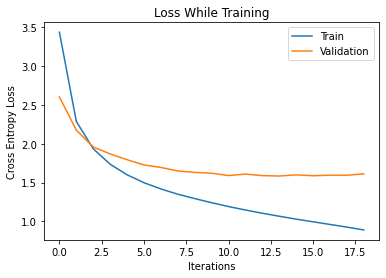

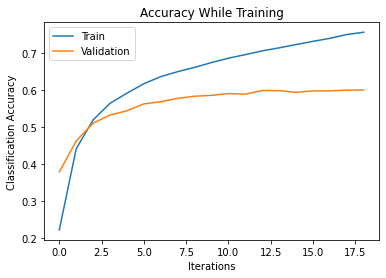

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

79/79 [==============================] - 0s 2ms/step


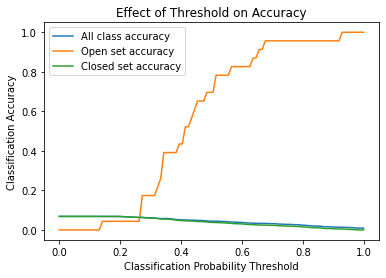

total accuracy:      0.0680
open-set accuracy:   0.0000
closed-set accuracy: 0.0686
optimal threshold:   0.0000


In [16]:

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)


# See how the threshold value affects open-set accuracy
threshold_value = np.linspace(0, 1, 100)

total_acc = []
open_set_acc = []
closed_set_acc = []

max_total_acc = 0
best_threshold = 0

for threshold in threshold_value:
    test_features = vectorizer.fit_transform(X_test).toarray()
    y_pred = threshold_predict(test_features, model, threshold)
    total_acc.append(accuracy(y_test_open, y_pred))
    open_set_acc.append(open_set_accuracy(y_test_open, y_pred))
    closed_set_acc.append(closed_set_accuracy(y_test_open, y_pred))
    
plot_open_closed_accuracy(total_acc, open_set_acc, closed_set_acc)

best_total_acc_idx = np.argmax(total_acc)
print('total accuracy:      {:.4f}'.format(float(total_acc[best_total_acc_idx])))
print('open-set accuracy:   {:.4f}'.format(float(open_set_acc[best_total_acc_idx])))
print('closed-set accuracy: {:.4f}'.format(float(closed_set_acc[best_total_acc_idx])))
print('optimal threshold:   {:.4f}'.format(float(threshold_value[best_total_acc_idx])))

In [17]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')
        self.bias = 0 # used to calibrate dummy logit to have same magnitude as rest of logits

    def _pre(self, inputs):
        return self.embed_pre(inputs)
    
    def _rest(self, inputs):
        x_post = self.embed_post(inputs)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
        return self.output_layer(all_logits)
        
    def call(self, inputs):
        x_pre = self._pre(inputs)
        return self._rest(x_pre)
        
    # def predict(self, x):
    #     """ Returns the predicted class label. If predicted class is dummy class, return -1
    #     indicating prediction falls within the open set.
    #     """
    #     y_pred = self.__call__(x)
    #     y_pred_labels = tf.argmax(y_pred, axis=1)
    #     return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/500
551/551 [==============================] - 6s 9ms/step - loss: 5.1311 - acc: 0.0096 - val_loss: 4.1147 - val_acc: 0.0497
Epoch 2/500
551/551 [==============================] - 4s 8ms/step - loss: 3.7574 - acc: 0.1013 - val_loss: 3.5155 - val_acc: 0.1471
Epoch 3/500
551/551 [==============================] - 4s 7ms/step - loss: 3.3470 - acc: 0.1762 - val_loss: 3.3016 - val_acc: 0.1961
Epoch 4/500
551/551 [==============================] - 4s 8ms/step - loss: 3.1377 - acc: 0.2173 - val_loss: 3.1960 - val_acc: 0.1862
Epoch 5/500
551/551 [==============================] - 4s 7ms/step - loss: 3.0044 - acc: 0.2472 - val_loss: 3.1077 - val_acc: 0.2462
Epoch 6/500
551/551 [==============================] - 4s 7ms/step - loss: 2.9025 - acc: 0.2682 - val_loss: 3.0583 - val_acc: 0.2570
Epoch 7/500
551/551 [==============================] - 4s 8ms/step - loss: 2.8253 - acc: 0.2834 - val_loss: 3.0171 - val_acc: 0.2422
Epoch 8/500
551/551 [==============================] - 5s 9ms/step - 

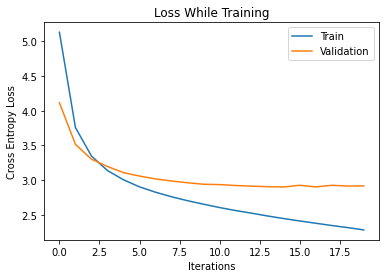

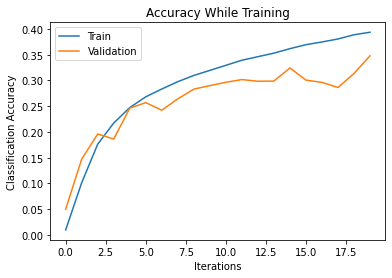

In [18]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [99] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)


num_placeholders = 120
pre_dim = post_dim = 200
model = OpenSetPlaceholdersLRM(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES - 1,
    num_placeholders=num_placeholders
)
beta = .75
loss = lambda *x: ce_loss_for_placeholders(*x, beta)
model.compile(
    optimizer='adam', 
    loss=loss, 
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)


# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()


y_train_one_hot = tf.one_hot(y_train_closed, depth=model.num_classes + 1)
y_val_one_hot = tf.one_hot(y_val_closed, depth=model.num_classes + 1)


es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, y_train_one_hot, batch_size=batch_size,
                  callbacks=[es_callback],
          epochs=epochs, validation_data=(dev_features, y_val_one_hot))


# y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
# history = model.fit(X_train_closed, y_train_one_hot, epochs=20, validation_split=.2, batch_size=32)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

In [19]:
total_acc = []
open_set_acc = []
closed_set_acc = []


test_features = vectorizer.transform(X_test).toarray()
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)
y_pred = model.predict(test_features)

y_pred_labels = tf.argmax(y_pred, axis=1)
y_pred_labels1 = tf.where(y_pred_labels == 99, -1, y_pred_labels)

# y_val_one_hot = tf.one_hot(y_val_closed, depth=model.num_classes + 1)

print('total accuracy:      {:.4f}'.format(accuracy(y_test_open, y_pred_labels1)))
print('open-set accuracy:   {:.4f}'.format(open_set_accuracy(y_test_open, y_pred_labels1)))
print('closed-set accuracy: {:.4f}'.format(closed_set_accuracy(y_test_open, y_pred_labels1)))

79/79 [==============================] - 0s 2ms/step
total accuracy:      0.3740
open-set accuracy:   0.9565
closed-set accuracy: 0.3686


###Under progress from here onwards

In [28]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tqdm import tqdm

In [30]:
def plot_training_metric(train_values, val_values, metric_name):
    iterations = list(range(len(train_values)))
    plt.plot(iterations, train_values, label='Train')
    plt.plot(iterations, val_values, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('{} While Training'.format(metric_name))
    plt.show()

In [35]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, num_classes, pre_dim=200, post_dim=200, *args, **kwargs):
        super().__init__(*args, **kwargs)
        lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim, activation=lrelu, name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation=lrelu, name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        logits = self.logits_layer(x_post)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

def train_SLRM(X, y, num_classes, epochs=25, plot=True, **kwargs):
    batch_size = 64
    vectorizer = TfidfVectorizer(max_features=250, sublinear_tf=True, ngram_range=(1,2))
    train_features = vectorizer.fit_transform(X_train).toarray()
    dev_features = vectorizer.transform(X_val).toarray()
    # y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=100)
    lb = LabelEncoder()
    ytrain = lb.fit_transform(y_train)
    dummy_y_train = np_utils.to_categorical(ytrain)

    yval = lb.fit_transform(y_val)
    dummy_y_dev = np_utils.to_categorical(yval)

    model = StandardLogisticRegressionModel( 
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        loss=ce_loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes, average='macro')]
    )
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        train_features, dummy_y_train, epochs=epochs, 
        callbacks=[model_checkpoint_callback], validation_data=(dev_features, dummy_y_dev)
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1114/1114 [==============================] - 5s 4ms/step - loss: 3.7727 - f1: 0.1300 - val_loss: 3.1090 - val_f1: 0.2197
Epoch 2/15
1114/1114 [==============================] - 4s 4ms/step - loss: 2.8575 - f1: 0.2815 - val_loss: 2.7055 - val_f1: 0.3145
Epoch 3/15
1114/1114 [==============================] - 4s 3ms/step - loss: 2.5508 - f1: 0.3495 - val_loss: 2.5012 - val_f1: 0.3668
Epoch 4/15
1114/1114 [==============================] - 5s 4ms/step - loss: 2.3636 - f1: 0.3954 - val_loss: 2.3566 - val_f1: 0.3923
Epoch 5/15
1114/1114 [==============================] - 8s 7ms/step - loss: 2.2235 - f1: 0.4301 - val_loss: 2.2572 - val_f1: 0.4220
Epoch 6/15
1114/1114 [==============================] - 4s 3ms/step - loss: 2.1089 - f1: 0.4587 - val_loss: 2.1723 - val_f1: 0.4481
Epoch 7/15
1114/1114 [==============================] - 5s 4ms/step - loss: 2.0185 - f1: 0.4820 - val_loss: 2.1008 - val_f1: 0.4628
Epoch 8/15
1114/1114 [==============================] - 6s 5ms/step - loss: 

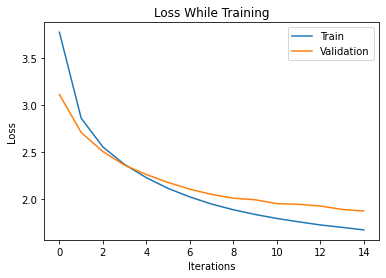

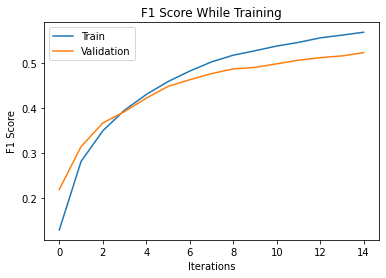

In [36]:
model = train_SLRM(X, y, num_classes=NUM_CLASSES, epochs=15, plot=True, pre_dim=50, post_dim=50)

In [44]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
from itertools import compress
    
def threshold_predict(X, model, threshold):
    # print(X)
    # y_pred = model.call(X)
    y_pred = model.predict(X)
    # print(y_pred)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = [y != label for label in class_labels]
    X = np.array(X) 
    result = X[to_remove_mask] 
    X=result.tolist()
    y = np.array(y) 
    result = y[to_remove_mask] 
    y=result.tolist()
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def closed_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    closed_set_idx = y_true != -1
    return accuracy(y_true[closed_set_idx], y_pred[closed_set_idx])
    #return tf.reduce_sum(tf.equal(y_true[closed_set_idx], y_pred[closed_set_idx]))
def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def open_set_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.where(y_true == -1, 1, 0)
    y_pred = tf.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred)
    
def known_fraction(y_pred):
    """Fraction of predicted class labels != -1"""
    return tf.reduce_sum(tf.cast(y_pred != -1, tf.int64)) / y_pred.shape

In [47]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
X, y, X_test, y_test = load_dataset()
open_set_class_labels = [99] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)



pre_dim = post_dim = 200
model = StandardLogisticRegressionModel(pre_dim, post_dim, NUM_CLASSES - 1)
model.compile(optimizer='adam', loss=ce_loss, metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')])





vectorizer = TfidfVectorizer(max_features=250, sublinear_tf=True, ngram_range=(1,2))
train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()

lb = LabelEncoder()
ytrain = lb.fit_transform(y_train_closed)
dummy_y_train = np_utils.to_categorical(ytrain)

yval = lb.fit_transform(y_val_closed)
dummy_y_dev = np_utils.to_categorical(yval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/25
1103/1103 [==============================] - 8s 6ms/step - loss: 3.1082 - f1: 0.2639 - val_loss: 2.3292 - val_f1: 0.4151
Epoch 2/25
1103/1103 [==============================] - 5s 5ms/step - loss: 2.0282 - f1: 0.4838 - val_loss: 1.9288 - val_f1: 0.4988
Epoch 3/25
1103/1103 [==============================] - 5s 4ms/step - loss: 1.7253 - f1: 0.5577 - val_loss: 1.7770 - val_f1: 0.5419
Epoch 4/25
1103/1103 [==============================] - 6s 5ms/step - loss: 1.5626 - f1: 0.5945 - val_loss: 1.6895 - val_f1: 0.5633
Epoch 5/25
1103/1103 [==============================] - 5s 5ms/step - loss: 1.4442 - f1: 0.6221 - val_loss: 1.6369 - val_f1: 0.5773
Epoch 6/25
1103/1103 [==============================] - 5s 4ms/step - loss: 1.3519 - f1: 0.6441 - val_loss: 1.5898 - val_f1: 0.5895
Epoch 7/25
1103/1103 [==============================] - 5s 4ms/step - loss: 1.2723 - f1: 0.6625 - val_loss: 1.5883 - val_f1: 0.5864
Epoch 8/25
1103/1103 [==============================] - 5s 5ms/step - loss: 

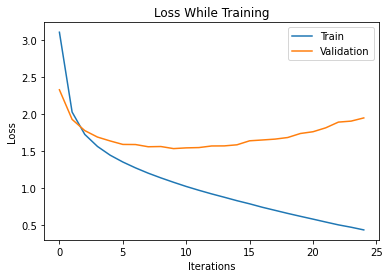

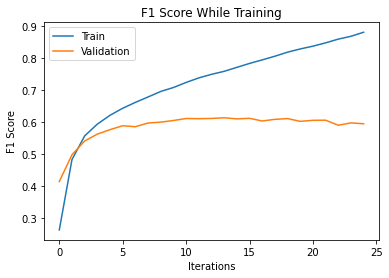

In [58]:
model = StandardLogisticRegressionModel( 
        num_classes=NUM_CLASSES-1,
        pre_dim=200, post_dim=200
)
model.compile(
  optimizer='adam', 
  loss=ce_loss, 
  metrics=[tfa.metrics.F1Score(name='f1', num_classes=NUM_CLASSES-1, average='macro')]
)

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_f1',
    mode='max',
    save_best_only=True
)
history = model.fit(
        train_features, dummy_y_train, epochs=25, 
        callbacks=[model_checkpoint_callback], validation_data=(dev_features, dummy_y_dev)
)
model.load_weights(checkpoint_filepath)
# if plot:
history = history.history
plot_training_metric(history['loss'], history['val_loss'], 'Loss')
plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')

In [59]:
def tune_model_param(model, val_closed, val_open, param_values, param_name, predict_func,
                     objective_func, target_value, objective_name, metrics, plot=True):
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val, open_set_class_labels)
    best_objective_error = float('inf')
    best_param_value = 0
    objective_values = []
    metric_values = {metric: [] for metric in metrics}
    for param_value in param_values:
        y_pred_closed = predict_func(val_closed['X'], model, param_value)
        y_pred_open = predict_func(val_open['X'], model, param_value)
        objective_values.append(objective_func(y_pred_closed))
        objective_error = float(abs(objective_values[-1] - target_value))
        if objective_error < best_objective_error:
            best_objective_error = objective_error
            best_param_value = param_value
        for metric in metrics:
            metric_values[metric].append(metrics[metric](val_open['y'], y_pred_open))
    if plot:
        for metric in metrics:
            plt.plot(param_values, metric_values[metric], label=metric)
        plt.plot(param_values, objective_values, label=objective_name)
        plt.xlabel(param_name)
        plt.legend()
        plt.title('Calibrating {}'.format(param_name))
        plt.show()
    return best_param_value

In [60]:
# See how the threshold value affects accuracy and find the threshold
# such that 95% of validation data is recognized as known

tuning_metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

def tune_TSLR_threshold(model, X_val, y_val, open_set_class_labels, plot=True):
    """Tunes a Thresholded-Standard-Logistic-Regression model's threshold so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    threshold_values = np.linspace(0, 1, 100)
    target_known_fraction = .95
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Classification Probability Threshold'
    objective_name = 'Known Fraction'
    threshold = tune_model_param(
        model, val_closed, val_open, threshold_values, param_name, threshold_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return threshold

In [61]:
threshold = tune_TSLR_threshold(model, X_val, y_val, open_set_class_labels)

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = threshold_predict(X_test, model, threshold)
print('Results from test set using 95% threshold ({:.4f}):'.format(threshold))
for metric in tuning_metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


ValueError: ignored

In [62]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')
        self.bias = 0 # used to calibrate dummy logit to have same magnitude as rest of logits

    def _pre(self, inputs):
        return self.embed_pre(inputs)
    
    def _rest(self, inputs):
        x_post = self.embed_post(inputs)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
        return self.output_layer(all_logits)
        
    def call(self, inputs):
        x_pre = self._pre(inputs)
        return self._rest(x_pre)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.call(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)    
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

def train_OSPLRM(X, y, num_classes, beta=.5, epochs=25, plot=True, **kwargs):
    model = OpenSetPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    loss = lambda *x: ce_loss_for_placeholders(*x, beta)
    model.compile(
        optimizer='adam', 
        loss=loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes + 1)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_split=.2, batch_size=32,
        callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

In [ ]:

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)


# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()


y_train_one_hot = tf.one_hot(y_train_closed, depth=model.num_classes + 1)
y_val_one_hot = tf.one_hot(y_val_closed, depth=model.num_classes + 1)


Epoch 1/25
552/552 [==============================] - 7s 10ms/step - loss: 5.7909 - f1: 0.0000e+00 - val_loss: 5.2226 - val_f1: 0.0000e+00
Epoch 2/25
552/552 [==============================] - 2s 4ms/step - loss: 4.7266 - f1: 0.0176 - val_loss: 4.3710 - val_f1: 0.0464
Epoch 3/25
552/552 [==============================] - 3s 5ms/step - loss: 4.1888 - f1: 0.0683 - val_loss: 4.0698 - val_f1: 0.0860
Epoch 4/25
552/552 [==============================] - 3s 5ms/step - loss: 3.9351 - f1: 0.1212 - val_loss: 3.8690 - val_f1: 0.1445
Epoch 5/25
552/552 [==============================] - 2s 4ms/step - loss: 3.7471 - f1: 0.1649 - val_loss: 3.7148 - val_f1: 0.1822
Epoch 6/25
552/552 [==============================] - 2s 4ms/step - loss: 3.6043 - f1: 0.2018 - val_loss: 3.6068 - val_f1: 0.2062
Epoch 7/25
552/552 [==============================] - 3s 5ms/step - loss: 3.4939 - f1: 0.2294 - val_loss: 3.5313 - val_f1: 0.2270
Epoch 8/25
552/552 [==============================] - 3s 5ms/step - loss: 3.4120 

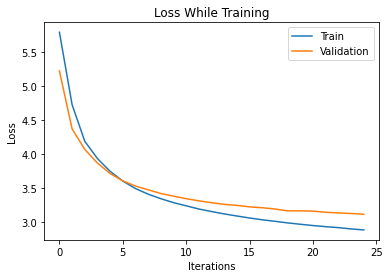

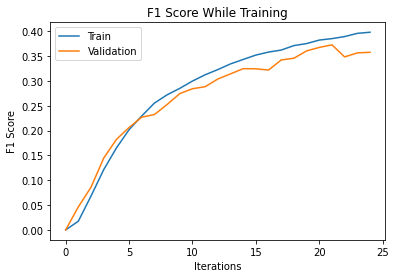

In [68]:


open_set_class_labels = [99] 



num_placeholders = 120
pre_dim = post_dim = 200

beta = .75
model = OpenSetPlaceholdersLRM(
        num_classes=NUM_CLASSES-1,
        num_placeholders=20,
        pre_dim=50,
        post_dim=50
)
loss = lambda *x: ce_loss_for_placeholders(*x, beta)
model.compile(
        optimizer='adam', 
        loss=loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=NUM_CLASSES-1+1, average='macro')]
)



es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, y_train_one_hot, batch_size=batch_size,
                  callbacks=[es_callback],
          epochs=25, validation_data=(dev_features, y_val_one_hot))


# y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
# history = model.fit(X_train_closed, y_train_one_hot, epochs=20, validation_split=.2, batch_size=32)

history = history.history
plot_training_metric(history['loss'], history['val_loss'], 'Loss')
plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')

In [69]:
# See how the bias value affects accuracy and find the bias
# such that 95% of validation data is recognized as known

def tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels, plot=True):
    """Tunes a Open-Set-Placeholders-Logistic-Regression model's bias so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    def placeholders_predict(X, model, bias):
        model.bias = bias
        return model.predict(X)

    target_known_fraction = .95
    bias_values = np.linspace(-2, 2, 100)
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Dummy Classifier Bias'
    objective_name = 'Known Fraction'
    bias = tune_model_param(
        model, val_closed, val_open, bias_values, param_name, placeholders_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return bias

In [70]:
bias = tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


TypeError: ignored